# GoEmotions Dataset - Comprehensive Exploratory Data Analysis (EDA)

## 🎯 Project Overview
This notebook provides a complete exploratory analysis of the GoEmotions dataset for emotion-aware customer feedback analysis. We'll examine the data structure, quality, distributions, and relationships to inform our preprocessing and modeling strategies.

**Dataset**: GoEmotions - Reddit comments labeled for 27 emotion categories + neutral  
**Use Case**: Multi-label emotion classification with explainable AI  
**Phase**: 1.3 - Data Foundation & EDA

## 📚 1. Import Required Libraries and Load Dataset

We'll import all necessary libraries for comprehensive data analysis and visualization.

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Text analysis
import re
from collections import Counter
from wordcloud import WordCloud

# Project-specific imports
import sys
sys.path.append('../')
from emotion_xai.data.preprocessing import load_dataset, clean_text
from emotion_xai.utils.device import resolve_device

# Configuration
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Device optimization for processing
device = resolve_device()
print(f"🚀 Using device: {device} for analysis")

print("✅ All libraries imported successfully!")

🚀 Using device: mps for analysis
✅ All libraries imported successfully!


In [3]:
# Load the GoEmotions dataset
data_path = '../data/raw/goemotions.csv'
df = pd.read_csv(data_path)

print("📊 Dataset loaded successfully!")
print(f"Dataset path: {data_path}")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Quick peek at the data
print("\n👀 First few rows:")
df.head()

📊 Dataset loaded successfully!
Dataset path: ../data/raw/goemotions.csv
Shape: (211225, 37)
Memory usage: 144.53 MB

👀 First few rows:


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 🧭 2. Dataset Overview and Basic Information

Let's understand the structure and basic characteristics of our dataset.

In [4]:
# Dataset shape and basic info
print("📏 DATASET SHAPE & STRUCTURE")
print("=" * 50)
print(f"Rows (samples): {df.shape[0]:,}")
print(f"Columns (features): {df.shape[1]:,}")
print(f"Total cells: {df.shape[0] * df.shape[1]:,}")

print("\n📋 COLUMN DATA TYPES")
print("=" * 50)
print(df.dtypes)

print("\n🔢 UNIQUE VALUES PER COLUMN")
print("=" * 50)
unique_counts = df.nunique().sort_values(ascending=False)
for col, count in unique_counts.head(15).items():
    print(f"{col:20} {count:>10,}")

if len(unique_counts) > 15:
    print(f"... and {len(unique_counts) - 15} more columns")

📏 DATASET SHAPE & STRUCTURE
Rows (samples): 211,225
Columns (features): 37
Total cells: 7,815,325

📋 COLUMN DATA TYPES
text                     object
id                       object
author                   object
subreddit                object
link_id                  object
parent_id                object
created_utc             float64
rater_id                  int64
example_very_unclear       bool
admiration                int64
amusement                 int64
anger                     int64
annoyance                 int64
approval                  int64
caring                    int64
confusion                 int64
curiosity                 int64
desire                    int64
disappointment            int64
disapproval               int64
disgust                   int64
embarrassment             int64
excitement                int64
fear                      int64
gratitude                 int64
grief                     int64
joy                       int64
love             

In [5]:
# Define emotion columns for analysis
emotion_cols = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

# Verify emotion columns exist
existing_emotions = [col for col in emotion_cols if col in df.columns]
missing_emotions = [col for col in emotion_cols if col not in df.columns]

print(f"✅ Emotion columns found: {len(existing_emotions)}/28")
if missing_emotions:
    print(f"❌ Missing emotions: {missing_emotions}")

# Summary statistics for numerical columns
print("\n📊 SUMMARY STATISTICS")
print("=" * 50)
df.describe(include='all')

✅ Emotion columns found: 28/28

📊 SUMMARY STATISTICS


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
count,211225,211225,211225,211225,211225,211225,2.112250e+05,211225.000000,211225,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000,211225.000000
unique,57732,58011,49178,483,44897,54924,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Thank you.,eew5j0j,[deleted],cringe,t3_ae6ejj,t3_ae6ejj,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,45,5,3882,895,92,64,NaN,NaN,207814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.547659e+09,37.619742,NaN,0.081103,0.043768,0.038272,0.064472,0.083418,0.028401,0.034840,0.045885,0.018071,0.040095,0.054085,0.025096,0.011722,0.026649,0.015136,0.055036,0.003186,0.037794,0.038779,0.008569,0.041259,0.006164,0.041591,0.006102,0.011954,0.031994,0.026105,0.261797
std,NaN,NaN,NaN,NaN,NaN,NaN,7.696842e+05,23.070528,NaN,0.272994,0.204580,0.191853,0.245592,0.276514,0.166116,0.183374,0.209236,0.133208,0.196182,0.226185,0.156418,0.107632,0.161057,0.122092,0.228051,0.056356,0.190698,0.193067,0.092172,0.198890,0.078269,0.199653,0.077880,0.108679,0.175985,0.159448,0.439614
min,NaN,NaN,NaN,NaN,NaN,NaN,1.546301e+09,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,1.546993e+09,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,1.547664e+09,37.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.548320e+09,57.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


## 🧹 3. Missing Values and Data Quality Assessment

Let's examine data quality issues including missing values, duplicates, and outliers.

In [6]:
# Missing values analysis
print("🔍 MISSING VALUES ANALYSIS")
print("=" * 50)

missing_counts = df.isnull().sum()
missing_percentages = (missing_counts / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentages.values
}).sort_values('Missing_Count', ascending=False)

# Show columns with missing values
cols_with_missing = missing_df[missing_df['Missing_Count'] > 0]
if len(cols_with_missing) > 0:
    print("Columns with missing values:")
    print(cols_with_missing)
else:
    print("✅ No missing values found!")

print(f"\nTotal missing values: {missing_counts.sum():,}")
print(f"Percentage of complete rows: {((len(df) - df.isnull().any(axis=1).sum()) / len(df) * 100):.2f}%")

🔍 MISSING VALUES ANALYSIS
✅ No missing values found!

Total missing values: 0
Percentage of complete rows: 100.00%


In [7]:
# Duplicates analysis
print("🔄 DUPLICATES ANALYSIS")
print("=" * 50)

# Check for duplicate rows
duplicate_rows = df.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows:,} ({duplicate_rows/len(df)*100:.2f}%)")

# Check for duplicate texts (more relevant for this dataset)
duplicate_texts = df['text'].duplicated().sum()
print(f"Duplicate texts: {duplicate_texts:,} ({duplicate_texts/len(df)*100:.2f}%)")

# Check for duplicate IDs
if 'id' in df.columns:
    duplicate_ids = df['id'].duplicated().sum()
    print(f"Duplicate IDs: {duplicate_ids:,} ({duplicate_ids/len(df)*100:.2f}%)")

# Show some duplicate texts if they exist
if duplicate_texts > 0:
    print("\n📝 Sample duplicate texts:")
    duplicate_text_examples = df[df['text'].duplicated(keep=False)]['text'].head(5)
    for i, text in enumerate(duplicate_text_examples, 1):
        print(f"{i}. {text[:100]}{'...' if len(text) > 100 else ''}")

🔄 DUPLICATES ANALYSIS
Duplicate rows: 0 (0.00%)
Duplicate texts: 153,493 (72.67%)
Duplicate IDs: 153,214 (72.54%)

📝 Sample duplicate texts:
1. That game hurt.
2.  >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits th...
3. You do right, if you don't care then fuck 'em!
4. Man I love reddit.
5. [NAME] was nowhere near them, he was by the Falcon. 
Duplicate texts: 153,493 (72.67%)
Duplicate IDs: 153,214 (72.54%)

📝 Sample duplicate texts:
1. That game hurt.
2.  >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits th...
3. You do right, if you don't care then fuck 'em!
4. Man I love reddit.
5. [NAME] was nowhere near them, he was by the Falcon. 


## 📏 4. Feature Types and Text Analysis

Let's analyze the different types of features and examine our text data characteristics.

In [8]:
# Feature type categorization
print("📊 FEATURE TYPE ANALYSIS")
print("=" * 50)

# Categorize columns
text_columns = ['text']
emotion_columns = existing_emotions
metadata_columns = [col for col in df.columns if col not in text_columns + emotion_columns]
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print(f"Text columns ({len(text_columns)}): {text_columns}")
print(f"Emotion columns ({len(emotion_columns)}): {emotion_columns[:5]}{'...' if len(emotion_columns) > 5 else ''}")
print(f"Metadata columns ({len(metadata_columns)}): {metadata_columns[:5]}{'...' if len(metadata_columns) > 5 else ''}")
print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns[:5]}{'...' if len(numerical_columns) > 5 else ''}")
print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns[:5]}{'...' if len(categorical_columns) > 5 else ''}")

# Text length analysis
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f"\n📝 TEXT CHARACTERISTICS")
print("=" * 50)
print(f"Average text length: {df['text_length'].mean():.1f} characters")
print(f"Average word count: {df['word_count'].mean():.1f} words")
print(f"Median text length: {df['text_length'].median():.1f} characters")
print(f"Median word count: {df['word_count'].median():.1f} words")
print(f"Max text length: {df['text_length'].max():,} characters")
print(f"Max word count: {df['word_count'].max():,} words")

📊 FEATURE TYPE ANALYSIS
Text columns (1): ['text']
Emotion columns (28): ['admiration', 'amusement', 'anger', 'annoyance', 'approval']...
Metadata columns (8): ['id', 'author', 'subreddit', 'link_id', 'parent_id']...
Numerical columns (30): ['created_utc', 'rater_id', 'admiration', 'amusement', 'anger']...
Categorical columns (6): ['text', 'id', 'author', 'subreddit', 'link_id']...

📝 TEXT CHARACTERISTICS
Average text length: 69.3 characters
Average word count: 13.0 words
Median text length: 67.0 characters
Median word count: 13.0 words
Max text length: 703 characters
Max word count: 33 words

📝 TEXT CHARACTERISTICS
Average text length: 69.3 characters
Average word count: 13.0 words
Median text length: 67.0 characters
Median word count: 13.0 words
Max text length: 703 characters
Max word count: 33 words


## 📈 5. Emotion Distribution Analysis

This section analyzes the distribution of emotions in the dataset, examining both individual emotion frequencies and multi-label patterns.

In [9]:
# Emotion frequency analysis
print("🎭 EMOTION DISTRIBUTION ANALYSIS")
print("=" * 50)

# Calculate emotion frequencies
emotion_counts = df[existing_emotions].sum().sort_values(ascending=False)
emotion_percentages = (emotion_counts / len(df) * 100).round(2)

print("Top 10 most frequent emotions:")
for emotion, count in emotion_counts.head(10).items():
    percentage = emotion_percentages[emotion]
    print(f"  {emotion:15} | {count:6,} samples ({percentage:5.2f}%)")

print("\nLeast frequent emotions:")
for emotion, count in emotion_counts.tail(5).items():
    percentage = emotion_percentages[emotion]
    print(f"  {emotion:15} | {count:6,} samples ({percentage:5.2f}%)")

# Multi-label statistics
df['total_emotions'] = df[existing_emotions].sum(axis=1)
print(f"\n📊 MULTI-LABEL STATISTICS")
print("=" * 50)
print(f"Average emotions per sample: {df['total_emotions'].mean():.2f}")
print(f"Median emotions per sample: {df['total_emotions'].median():.1f}")
print(f"Max emotions per sample: {df['total_emotions'].max()}")
print(f"Samples with no emotions: {len(df[df['total_emotions'] == 0]):,}")
print(f"Samples with multiple emotions: {len(df[df['total_emotions'] > 1]):,} ({len(df[df['total_emotions'] > 1])/len(df)*100:.1f}%)")

# Emotion co-occurrence (most common combinations)
print(f"\n🔗 EMOTION CO-OCCURRENCE")
print("=" * 50)
multi_emotion_samples = df[df['total_emotions'] > 1]
if len(multi_emotion_samples) > 0:
    print(f"Analyzing {len(multi_emotion_samples):,} samples with multiple emotions...")
    # Find most common emotion pairs
    from itertools import combinations
    emotion_pairs = []
    for _, row in multi_emotion_samples.iterrows():
        active_emotions = [col for col in existing_emotions if row[col] == 1]
        if len(active_emotions) >= 2:
            for pair in combinations(active_emotions, 2):
                emotion_pairs.append(tuple(sorted(pair)))
    
    if emotion_pairs:
        from collections import Counter
        pair_counts = Counter(emotion_pairs)
        print("Top 10 emotion pairs:")
        for (e1, e2), count in pair_counts.most_common(10):
            print(f"  {e1} + {e2}: {count:,} times")
else:
    print("No multi-emotion samples found.")

🎭 EMOTION DISTRIBUTION ANALYSIS
Top 10 most frequent emotions:
  neutral         | 55,298 samples (26.18%)
  approval        | 17,620 samples ( 8.34%)
  admiration      | 17,131 samples ( 8.11%)
  annoyance       | 13,618 samples ( 6.45%)
  gratitude       | 11,625 samples ( 5.50%)
  disapproval     | 11,424 samples ( 5.41%)
  curiosity       |  9,692 samples ( 4.59%)
  amusement       |  9,245 samples ( 4.38%)
  realization     |  8,785 samples ( 4.16%)
  optimism        |  8,715 samples ( 4.13%)

Least frequent emotions:
  embarrassment   |  2,476 samples ( 1.17%)
  nervousness     |  1,810 samples ( 0.86%)
  pride           |  1,302 samples ( 0.62%)
  relief          |  1,289 samples ( 0.61%)
  grief           |    673 samples ( 0.32%)

📊 MULTI-LABEL STATISTICS
Average emotions per sample: 1.18
Median emotions per sample: 1.0
Max emotions per sample: 12
Samples with no emotions: 3,411
Samples with multiple emotions: 35,994 (17.0%)

🔗 EMOTION CO-OCCURRENCE
Analyzing 35,994 samples wi

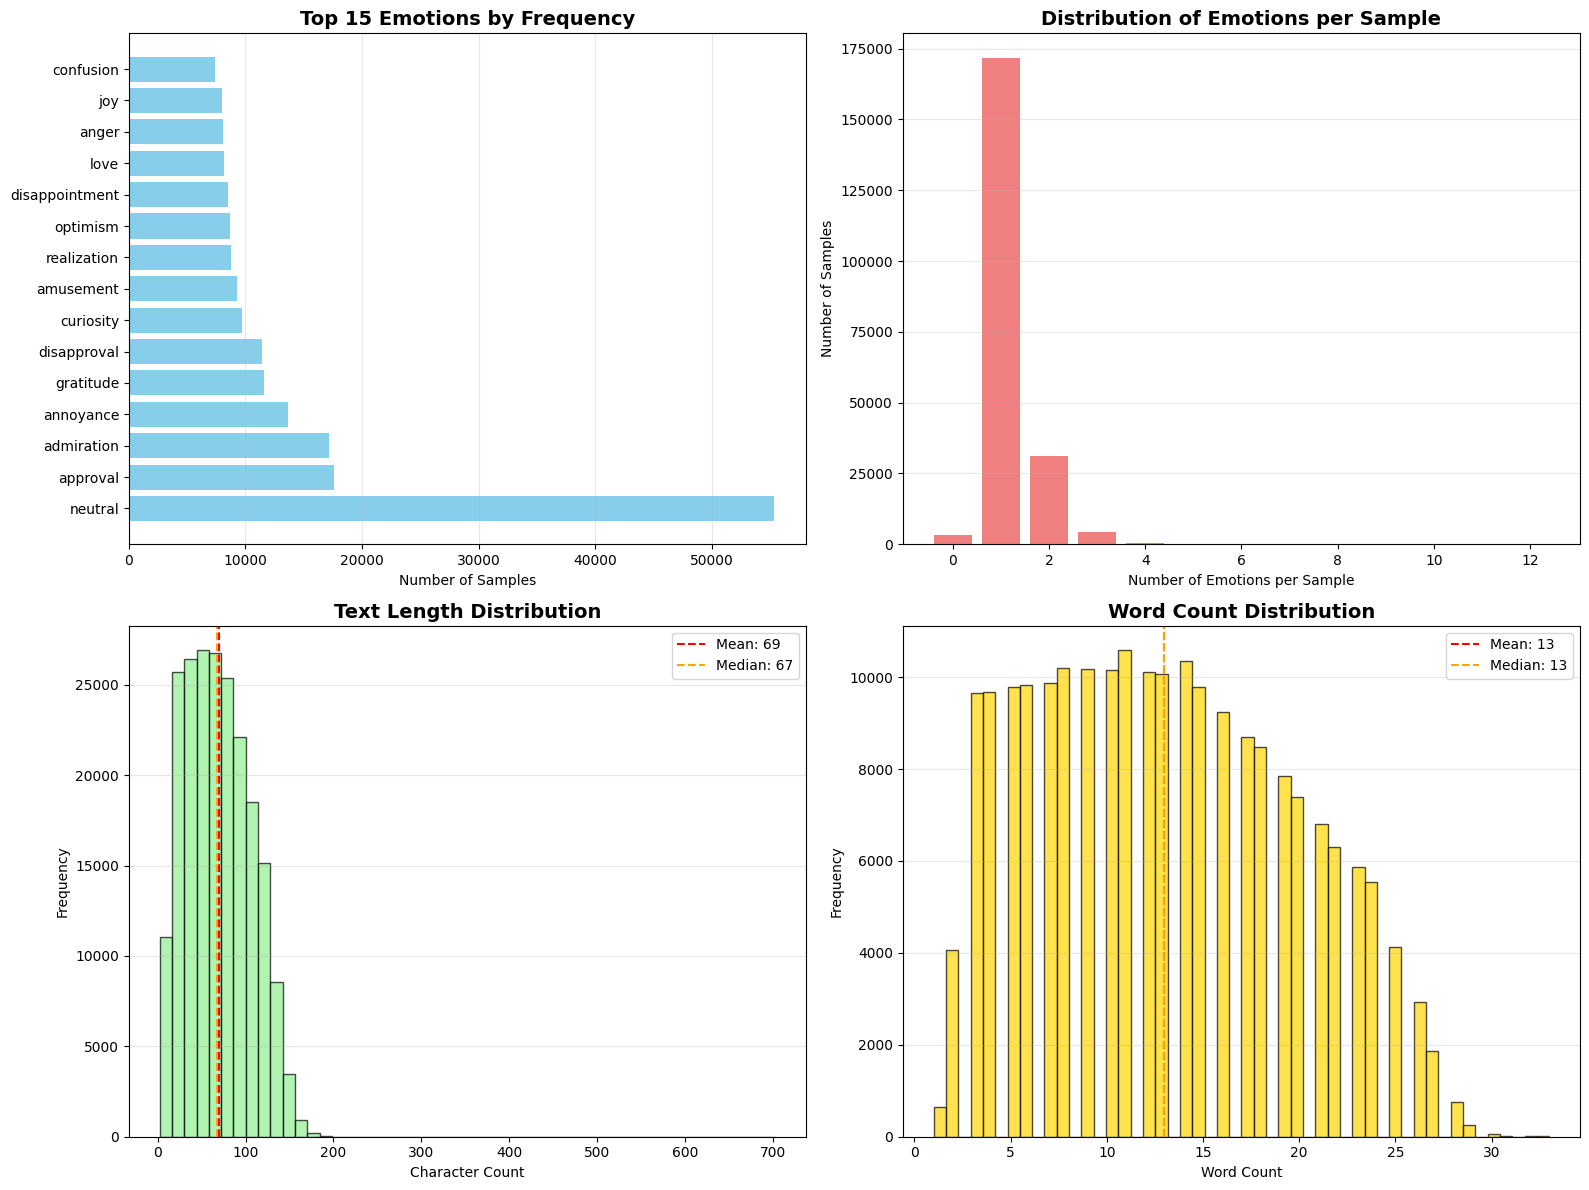

In [10]:
# Visualization: Emotion distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top emotions bar plot
axes[0, 0].barh(emotion_counts.head(15).index, emotion_counts.head(15).values, color='skyblue')
axes[0, 0].set_title('Top 15 Emotions by Frequency', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Samples')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Emotions per sample distribution
emotion_dist = df['total_emotions'].value_counts().sort_index()
axes[0, 1].bar(emotion_dist.index, emotion_dist.values, color='lightcoral')
axes[0, 1].set_title('Distribution of Emotions per Sample', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Emotions per Sample')
axes[0, 1].set_ylabel('Number of Samples')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Text length distribution
axes[1, 0].hist(df['text_length'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["text_length"].mean():.0f}')
axes[1, 0].axvline(df['text_length'].median(), color='orange', linestyle='--', label=f'Median: {df["text_length"].median():.0f}')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Word count distribution
axes[1, 1].hist(df['word_count'], bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.0f}')
axes[1, 1].axvline(df['word_count'].median(), color='orange', linestyle='--', label=f'Median: {df["word_count"].median():.0f}')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 🔍 6. Text Content Analysis

This section performs detailed analysis of the text content, including common words, patterns, and linguistic characteristics.

In [11]:
# Text content analysis
import re
from collections import Counter
import string

print("📝 TEXT CONTENT ANALYSIS")
print("=" * 50)

# Sample text inspection
print("Sample texts:")
for i, text in enumerate(df['text'].head(10), 1):
    print(f"{i:2d}. {text[:100]}{'...' if len(text) > 100 else ''}")

# Character analysis
def analyze_text_characteristics(texts):
    """Analyze various text characteristics"""
    has_urls = texts.str.contains(r'http[s]?://|www\.', case=False, na=False)
    has_mentions = texts.str.contains(r'@\w+', case=False, na=False)
    has_hashtags = texts.str.contains(r'#\w+', case=False, na=False)
    has_numbers = texts.str.contains(r'\d', na=False)
    has_special_chars = texts.str.contains(r'[^\w\s]', na=False)
    has_uppercase = texts.str.contains(r'[A-Z]', na=False)
    all_caps_words = texts.str.findall(r'\b[A-Z]{2,}\b').str.len()
    
    return {
        'urls': has_urls.sum(),
        'mentions': has_mentions.sum(), 
        'hashtags': has_hashtags.sum(),
        'numbers': has_numbers.sum(),
        'special_chars': has_special_chars.sum(),
        'uppercase': has_uppercase.sum(),
        'avg_caps_words': all_caps_words.mean()
    }

char_stats = analyze_text_characteristics(df['text'])
print(f"\nText characteristics:")
for characteristic, count in char_stats.items():
    if characteristic == 'avg_caps_words':
        print(f"  Average ALL-CAPS words per text: {count:.2f}")
    else:
        percentage = count / len(df) * 100
        print(f"  Texts with {characteristic}: {count:,} ({percentage:.1f}%)")

# Basic text statistics
print(f"\n📊 TEXT STATISTICS")
print("=" * 50)
print(f"Shortest text: {df['text_length'].min()} characters")
print(f"Longest text: {df['text_length'].max()} characters") 
print(f"Texts with < 10 characters: {len(df[df['text_length'] < 10]):,}")
print(f"Texts with > 500 characters: {len(df[df['text_length'] > 500]):,}")
print(f"Empty texts: {df['text'].isna().sum() + (df['text'] == '').sum()}")

# Language detection (basic patterns)
non_ascii_pattern = df['text'].str.contains(r'[^\x00-\x7F]', na=False)
print(f"Texts with non-ASCII characters: {non_ascii_pattern.sum():,} ({non_ascii_pattern.sum()/len(df)*100:.1f}%)")

📝 TEXT CONTENT ANALYSIS
Sample texts:
 1. That game hurt.
 2.  >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits th...
 3. You do right, if you don't care then fuck 'em!
 4. Man I love reddit.
 5. [NAME] was nowhere near them, he was by the Falcon. 
 6. Right? Considering it’s such an important document, I should know the damned thing backwards and for...
 7. He isn't as big, but he's still quite popular. I've heard the same thing about his content. Never wa...
 8. That's crazy; I went to a super [RELIGION] high school and I think I can remember 2 girls the entire...
 9. that's adorable asf
10. "Sponge Blurb Pubs Quaw Haha GURR ha AAa!" finale is too real

Text characteristics:
  Texts with urls: 0 (0.0%)
  Texts with mentions: 33 (0.0%)
  Texts with hashtags: 633 (0.3%)
  Texts with numbers: 18,536 (8.8%)
  Texts with special_chars: 191,642 (90.7%)
  Texts with uppercase: 201,703 (95.5%)
  Average ALL-CAPS words per text: 0.36

📊 TEXT STA

In [12]:
# Word frequency analysis (basic)
print(f"\n🔤 WORD FREQUENCY ANALYSIS")
print("=" * 50)

# Simple word tokenization and frequency
all_text = ' '.join(df['text'].fillna('').astype(str))
# Basic cleaning
all_text_clean = re.sub(r'[^\w\s]', ' ', all_text.lower())
words = all_text_clean.split()

# Remove common stop words (basic list)
stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'their'}

filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
word_freq = Counter(filtered_words)

print("Top 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"  {word:15} | {count:6,} occurrences")

print(f"\nTotal unique words: {len(word_freq):,}")
print(f"Total words (after filtering): {len(filtered_words):,}")
print(f"Average word length: {np.mean([len(w) for w in filtered_words]):.1f} characters")

# Emotion-specific word analysis (sample for top 3 emotions)
print(f"\n🎭 EMOTION-SPECIFIC WORD PATTERNS")
print("=" * 50)

top_3_emotions = emotion_counts.head(3).index.tolist()
for emotion in top_3_emotions:
    emotion_texts = df[df[emotion] == 1]['text'].fillna('').astype(str)
    if len(emotion_texts) > 0:
        emotion_text = ' '.join(emotion_texts)
        emotion_text_clean = re.sub(r'[^\w\s]', ' ', emotion_text.lower())
        emotion_words = [word for word in emotion_text_clean.split() if word not in stop_words and len(word) > 2]
        emotion_word_freq = Counter(emotion_words)
        
        print(f"\n{emotion.upper()} emotion - Top 10 words:")
        for word, count in emotion_word_freq.most_common(10):
            print(f"  {word:12} | {count:5,}")
    else:
        print(f"\n{emotion.upper()}: No samples found")


🔤 WORD FREQUENCY ANALYSIS
Top 20 most common words:
  name            | 38,233 occurrences
  not             | 18,722 occurrences
  just            | 17,219 occurrences
  like            | 16,421 occurrences
  what            | 13,342 occurrences
  don             | 10,639 occurrences
  all             | 10,096 occurrences
  about           |  9,810 occurrences
  get             |  9,185 occurrences
  one             |  9,016 occurrences
  people          |  8,745 occurrences
  love            |  8,415 occurrences
  good            |  8,284 occurrences
  how             |  8,227 occurrences
  there           |  8,104 occurrences
  out             |  8,083 occurrences
  from            |  7,248 occurrences
  think           |  7,221 occurrences
  really          |  7,134 occurrences
  when            |  7,123 occurrences

Total unique words: 30,035
Total words (after filtering): 1,589,547
Average word length: 5.3 characters

🎭 EMOTION-SPECIFIC WORD PATTERNS
Top 20 most common words:
  

## 🔗 7. Correlation Analysis

This section examines correlations between emotions and identifies patterns in the multi-label emotion space.

In [13]:
# Correlation analysis between emotions
print("🔗 EMOTION CORRELATION ANALYSIS")
print("=" * 50)

# Calculate correlation matrix for emotions
emotion_corr = df[existing_emotions].corr()

# Find strongest positive correlations (excluding self-correlations)
corr_pairs = []
for i, emotion1 in enumerate(existing_emotions):
    for j, emotion2 in enumerate(existing_emotions):
        if i < j:  # Avoid duplicates and self-correlations
            corr_value = emotion_corr.loc[emotion1, emotion2]
            corr_pairs.append((emotion1, emotion2, corr_value))

# Sort by correlation strength
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

print("Top 15 strongest correlations:")
for emotion1, emotion2, corr in corr_pairs_sorted[:15]:
    direction = "positive" if corr > 0 else "negative"
    print(f"  {emotion1:15} ↔ {emotion2:15} | {corr:6.3f} ({direction})")

print(f"\nCorrelation statistics:")
all_corrs = [corr for _, _, corr in corr_pairs]
print(f"  Average correlation: {np.mean(all_corrs):.4f}")
print(f"  Median correlation: {np.median(all_corrs):.4f}")
print(f"  Max correlation: {np.max(all_corrs):.4f}")
print(f"  Min correlation: {np.min(all_corrs):.4f}")
print(f"  Std correlation: {np.std(all_corrs):.4f}")

# Correlations with text features
print(f"\n📝 TEXT FEATURE CORRELATIONS")
print("=" * 50)

text_features = ['text_length', 'word_count', 'total_emotions']
text_emotion_corr = df[text_features + existing_emotions].corr()

for feature in text_features:
    feature_corrs = text_emotion_corr[feature][existing_emotions].sort_values(key=abs, ascending=False)
    print(f"\n{feature.upper()} correlations with emotions:")
    print("Top 10 strongest correlations:")
    for emotion, corr in feature_corrs.head(10).items():
        direction = "↗" if corr > 0 else "↘"
        print(f"  {emotion:15} {direction} {corr:6.3f}")

# Emotion clustering tendency
print(f"\n🎯 EMOTION CO-OCCURRENCE PATTERNS")
print("=" * 50)

# Calculate Jaccard similarity for emotion pairs
def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two binary vectors"""
    intersection = np.sum(set1 & set2)
    union = np.sum(set1 | set2)
    return intersection / union if union > 0 else 0

jaccard_pairs = []
for i, emotion1 in enumerate(existing_emotions):
    for j, emotion2 in enumerate(existing_emotions):
        if i < j:
            set1 = df[emotion1].values.astype(bool)
            set2 = df[emotion2].values.astype(bool)
            jaccard = jaccard_similarity(set1, set2)
            jaccard_pairs.append((emotion1, emotion2, jaccard))

# Sort by Jaccard similarity
jaccard_sorted = sorted(jaccard_pairs, key=lambda x: x[2], reverse=True)

print("Top 10 emotion pairs by co-occurrence (Jaccard similarity):")
for emotion1, emotion2, jaccard in jaccard_sorted[:10]:
    print(f"  {emotion1:15} + {emotion2:15} | {jaccard:6.3f}")

print(f"\nJaccard similarity statistics:")
all_jaccard = [jaccard for _, _, jaccard in jaccard_pairs]
print(f"  Average Jaccard: {np.mean(all_jaccard):.4f}")
print(f"  Median Jaccard: {np.median(all_jaccard):.4f}")
print(f"  Max Jaccard: {np.max(all_jaccard):.4f}")

🔗 EMOTION CORRELATION ANALYSIS
Top 15 strongest correlations:
  fear            ↔ nervousness     |  0.195 (positive)
  approval        ↔ neutral         | -0.180 (negative)
  admiration      ↔ neutral         | -0.177 (negative)
  annoyance       ↔ neutral         | -0.156 (negative)
  gratitude       ↔ neutral         | -0.144 (negative)
  disapproval     ↔ neutral         | -0.142 (negative)
  curiosity       ↔ neutral         | -0.131 (negative)
  amusement       ↔ neutral         | -0.127 (negative)
  realization     ↔ neutral         | -0.124 (negative)
  optimism        ↔ neutral         | -0.124 (negative)
  disappointment  ↔ neutral         | -0.122 (negative)
  love            ↔ neutral         | -0.120 (negative)
  anger           ↔ neutral         | -0.119 (negative)
  joy             ↔ neutral         | -0.118 (negative)
  confusion       ↔ neutral         | -0.113 (negative)

Correlation statistics:
  Average correlation: -0.0188
  Median correlation: -0.0143
  Max correl

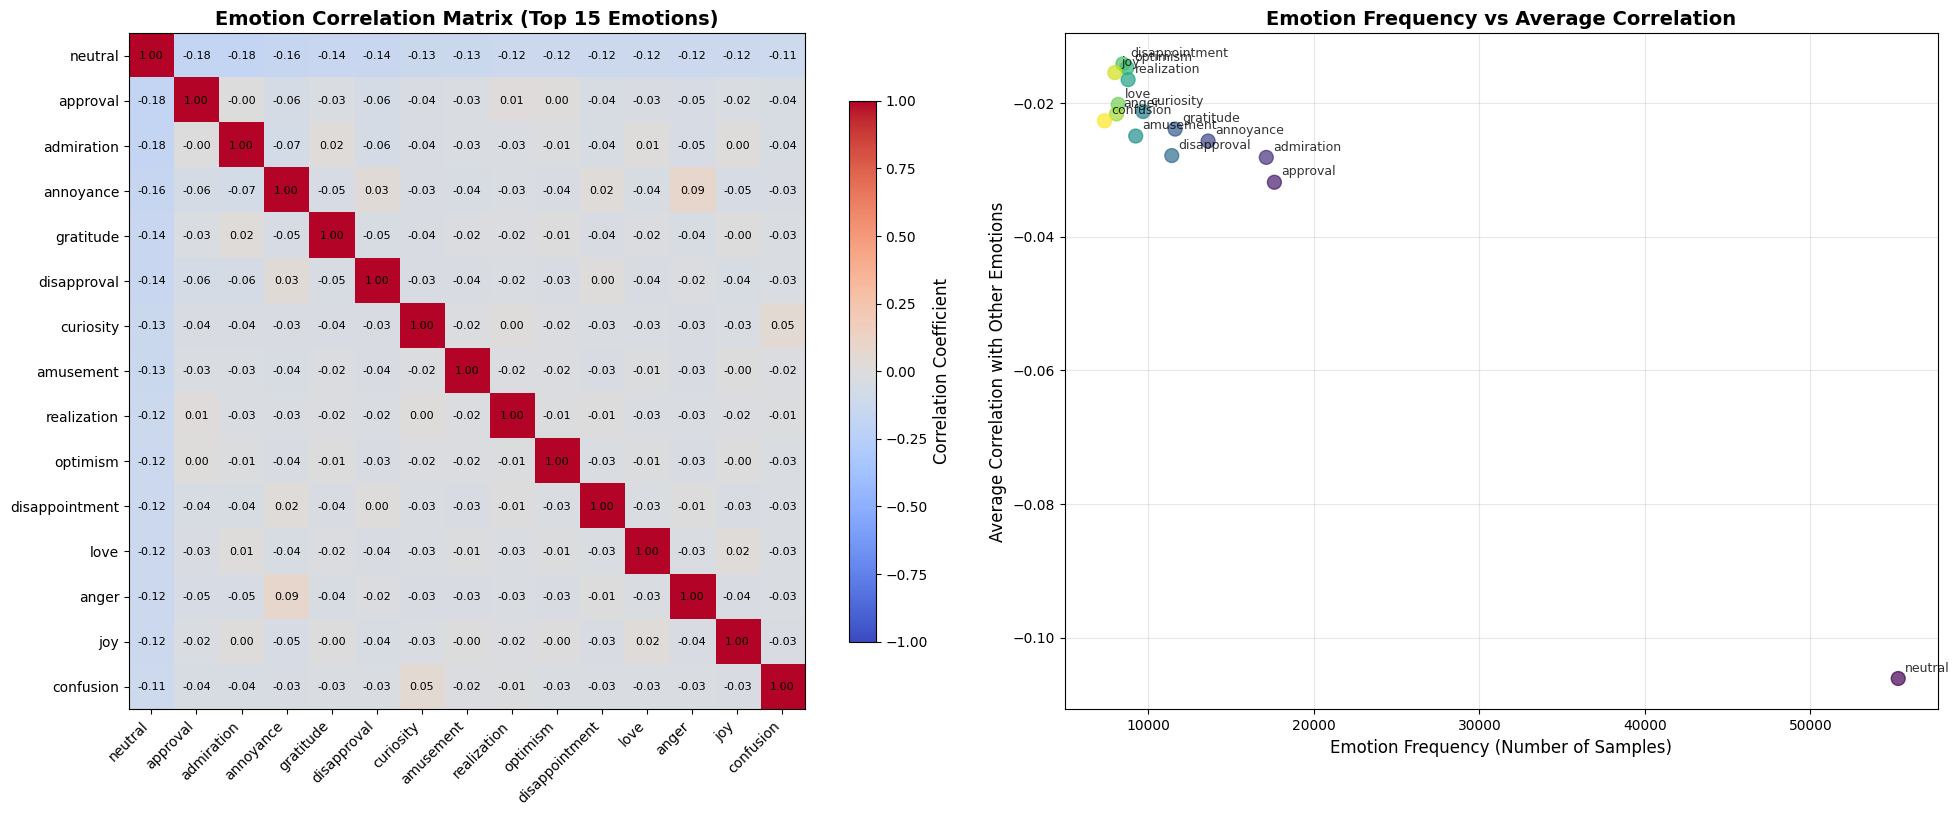

In [14]:
# Correlation heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Full correlation matrix (showing top emotions for readability)
top_emotions = emotion_counts.head(15).index.tolist()
corr_subset = emotion_corr.loc[top_emotions, top_emotions]

im1 = axes[0].imshow(corr_subset.values, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Emotion Correlation Matrix (Top 15 Emotions)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(top_emotions)))
axes[0].set_yticks(range(len(top_emotions)))
axes[0].set_xticklabels(top_emotions, rotation=45, ha='right')
axes[0].set_yticklabels(top_emotions)

# Add correlation values to heatmap
for i in range(len(top_emotions)):
    for j in range(len(top_emotions)):
        text = axes[0].text(j, i, f'{corr_subset.iloc[i, j]:.2f}', 
                           ha="center", va="center", color="black", fontsize=8)

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0], shrink=0.8)
cbar1.set_label('Correlation Coefficient', fontsize=12)

# 2. Emotion frequency vs average correlation
emotion_avg_corr = []
for emotion in existing_emotions:
    other_emotions = [e for e in existing_emotions if e != emotion]
    avg_corr = emotion_corr[emotion][other_emotions].mean()
    emotion_avg_corr.append((emotion, emotion_counts[emotion], avg_corr))

# Sort by frequency for plotting
emotion_avg_corr.sort(key=lambda x: x[1], reverse=True)
emotions_plot = [x[0] for x in emotion_avg_corr[:15]]
frequencies = [x[1] for x in emotion_avg_corr[:15]]
avg_corrs = [x[2] for x in emotion_avg_corr[:15]]

scatter = axes[1].scatter(frequencies, avg_corrs, alpha=0.7, s=100, c=range(len(emotions_plot)), cmap='viridis')
axes[1].set_xlabel('Emotion Frequency (Number of Samples)', fontsize=12)
axes[1].set_ylabel('Average Correlation with Other Emotions', fontsize=12)
axes[1].set_title('Emotion Frequency vs Average Correlation', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add emotion labels to points
for i, emotion in enumerate(emotions_plot):
    axes[1].annotate(emotion, (frequencies[i], avg_corrs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)

plt.tight_layout()
plt.show()

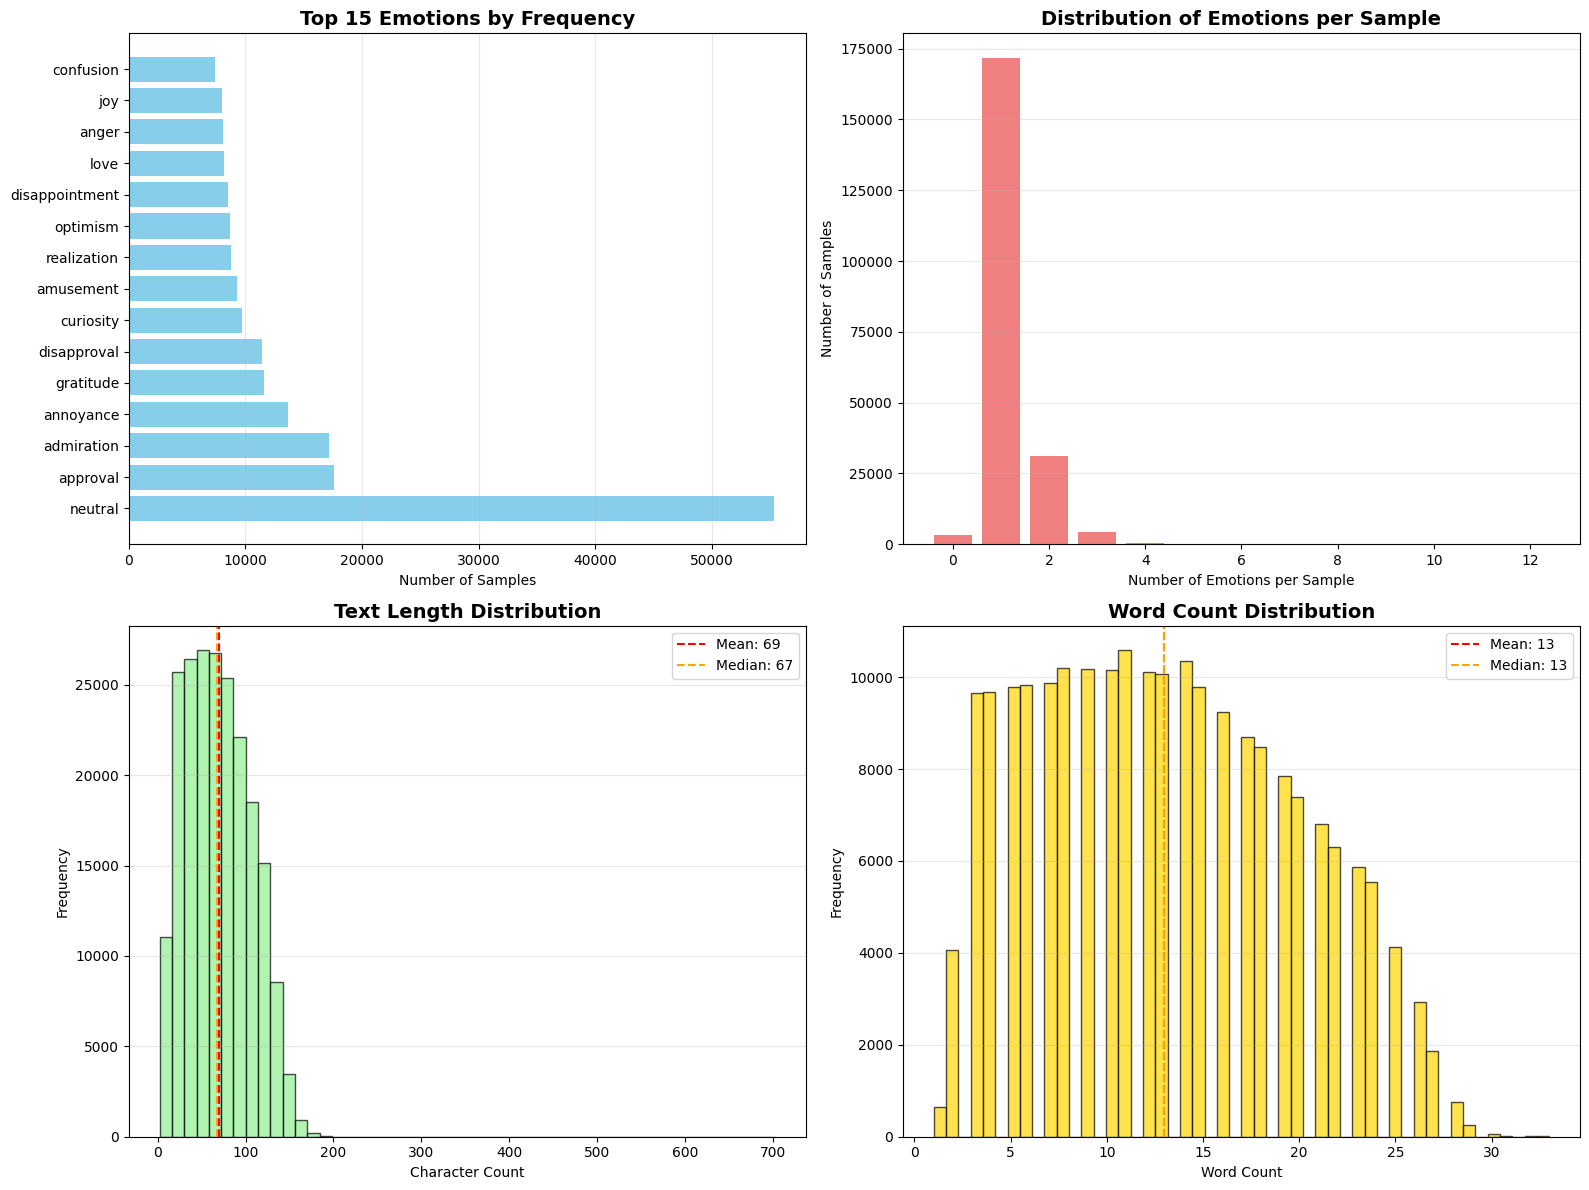

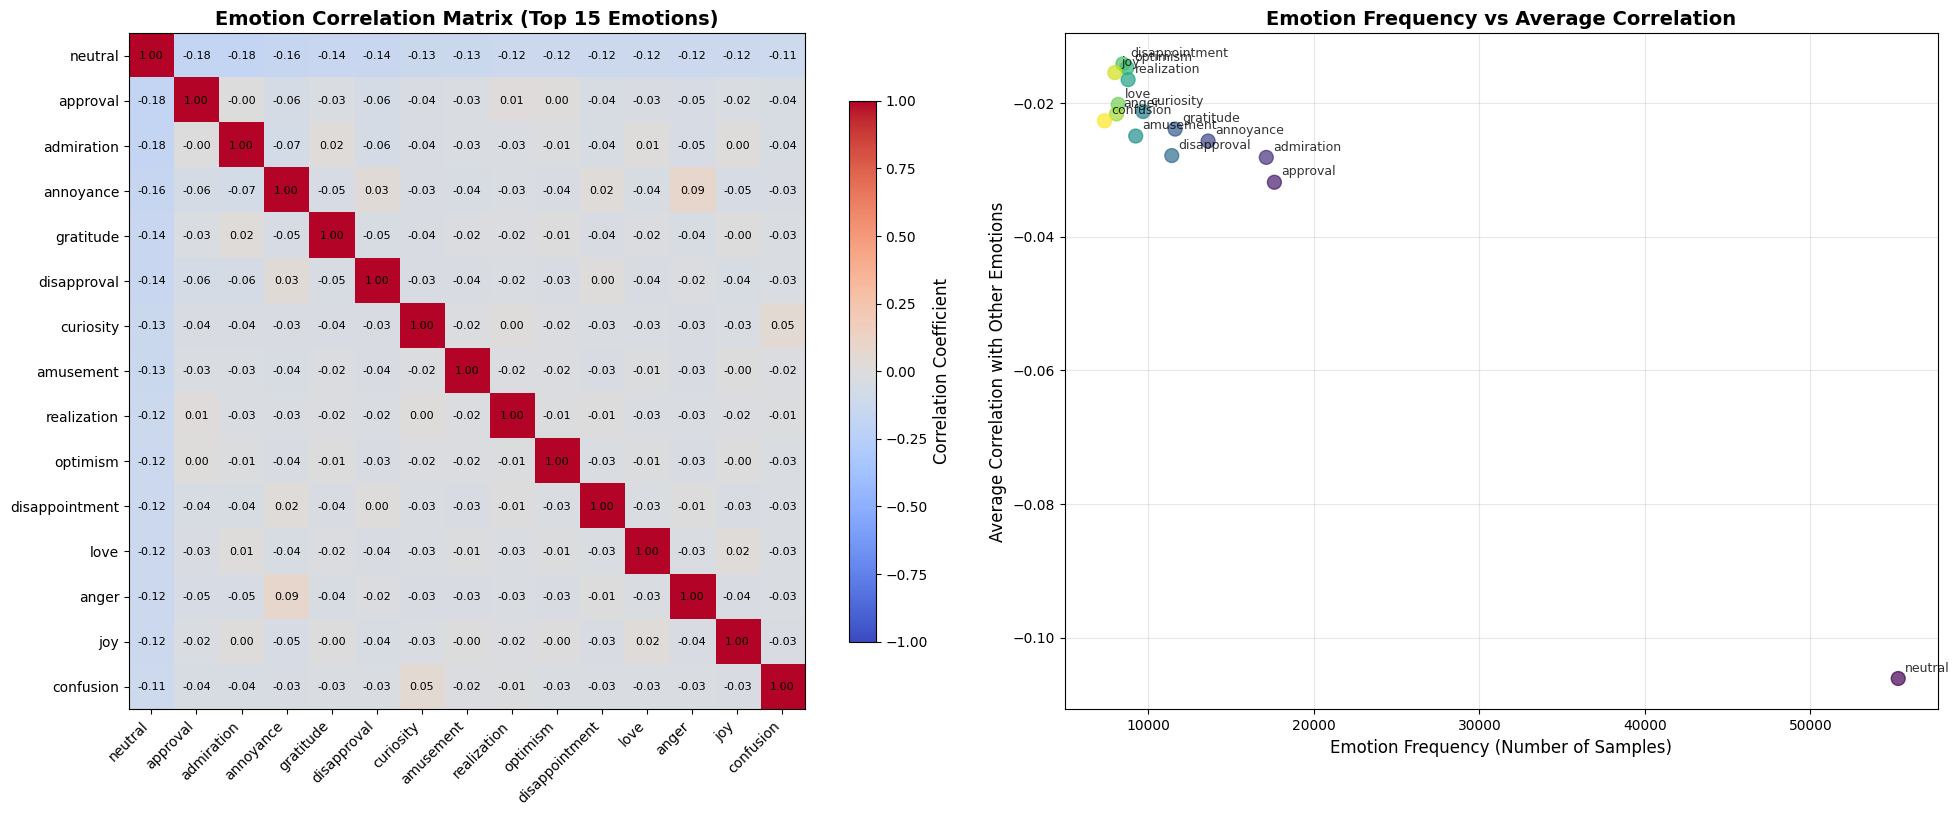

📊 Plots saved to:
   • ../results/plots/eda_plots/emotion_distribution_analysis_20251128_035705.png
   • ../results/plots/eda_plots/emotion_correlations_20251128_035705.png


In [20]:
# Save the visualizations to results/plots/eda_plots/
import os
from datetime import datetime

# Create timestamp for file naming
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plots_dir = '../results/plots/eda_plots'

# Recreate temporary columns for visualization
text_length = df['text'].str.len()
word_count = df['text'].str.split().str.len()
total_emotions = df[existing_emotions].sum(axis=1)

# Save the emotion distribution plots (recreate with save)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top emotions bar plot
axes[0, 0].barh(emotion_counts.head(15).index, emotion_counts.head(15).values, color='skyblue')
axes[0, 0].set_title('Top 15 Emotions by Frequency', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Samples')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Emotions per sample distribution  
emotion_dist = total_emotions.value_counts().sort_index()
axes[0, 1].bar(emotion_dist.index, emotion_dist.values, color='lightcoral')
axes[0, 1].set_title('Distribution of Emotions per Sample', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Emotions per Sample')
axes[0, 1].set_ylabel('Number of Samples')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Text length distribution
axes[1, 0].hist(text_length, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Text Length Distribution', fontsize=14, fontweight='bold') 
axes[1, 0].set_xlabel('Character Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(text_length.mean(), color='red', linestyle='--', label=f'Mean: {text_length.mean():.0f}')
axes[1, 0].axvline(text_length.median(), color='orange', linestyle='--', label=f'Median: {text_length.median():.0f}')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Word count distribution
axes[1, 1].hist(word_count, bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Word Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(word_count.mean(), color='red', linestyle='--', label=f'Mean: {word_count.mean():.0f}')
axes[1, 1].axvline(word_count.median(), color='orange', linestyle='--', label=f'Median: {word_count.median():.0f}')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
# Save the plot
emotion_dist_plot = os.path.join(plots_dir, f'emotion_distribution_analysis_{timestamp}.png')
plt.savefig(emotion_dist_plot, dpi=300, bbox_inches='tight')
plt.show()

# Save the correlation heatmap (recreate with save)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Full correlation matrix (showing top emotions for readability)
top_emotions = emotion_counts.head(15).index.tolist()
corr_subset = emotion_corr.loc[top_emotions, top_emotions]

im1 = axes[0].imshow(corr_subset.values, cmap='coolwarm', vmin=-1, vmax=1)
axes[0].set_title('Emotion Correlation Matrix (Top 15 Emotions)', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(top_emotions)))
axes[0].set_yticks(range(len(top_emotions)))
axes[0].set_xticklabels(top_emotions, rotation=45, ha='right')
axes[0].set_yticklabels(top_emotions)

# Add correlation values to heatmap
for i in range(len(top_emotions)):
    for j in range(len(top_emotions)):
        text = axes[0].text(j, i, f'{corr_subset.iloc[i, j]:.2f}', 
                           ha="center", va="center", color="black", fontsize=8)

# Add colorbar
cbar1 = plt.colorbar(im1, ax=axes[0], shrink=0.8)
cbar1.set_label('Correlation Coefficient', fontsize=12)

# 2. Emotion frequency vs average correlation
emotion_avg_corr = []
for emotion in existing_emotions:
    other_emotions = [e for e in existing_emotions if e != emotion]
    avg_corr = emotion_corr[emotion][other_emotions].mean()
    emotion_avg_corr.append((emotion, emotion_counts[emotion], avg_corr))

# Sort by frequency for plotting
emotion_avg_corr.sort(key=lambda x: x[1], reverse=True)
emotions_plot = [x[0] for x in emotion_avg_corr[:15]]
frequencies = [x[1] for x in emotion_avg_corr[:15]]  
avg_corrs = [x[2] for x in emotion_avg_corr[:15]]

scatter = axes[1].scatter(frequencies, avg_corrs, alpha=0.7, s=100, c=range(len(emotions_plot)), cmap='viridis')
axes[1].set_xlabel('Emotion Frequency (Number of Samples)', fontsize=12)
axes[1].set_ylabel('Average Correlation with Other Emotions', fontsize=12)
axes[1].set_title('Emotion Frequency vs Average Correlation', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add emotion labels to points
for i, emotion in enumerate(emotions_plot):
    axes[1].annotate(emotion, (frequencies[i], avg_corrs[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9, alpha=0.8)

plt.tight_layout()
# Save the correlation plot
correlation_plot = os.path.join(plots_dir, f'emotion_correlations_{timestamp}.png') 
plt.savefig(correlation_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Plots saved to:")
print(f"   • {emotion_dist_plot}")
print(f"   • {correlation_plot}")

## 🎯 8. Data Quality Assessment

This section evaluates data quality issues and provides recommendations for preprocessing.

In [15]:
# Data quality assessment
print("🎯 DATA QUALITY ASSESSMENT")
print("=" * 50)

# Text quality issues
def assess_text_quality(texts):
    """Assess various text quality issues"""
    issues = {}
    
    # Very short texts (< 5 characters)
    issues['very_short'] = (texts.str.len() < 5).sum()
    
    # Very long texts (> 1000 characters) 
    issues['very_long'] = (texts.str.len() > 1000).sum()
    
    # Texts with mostly punctuation
    mostly_punct = texts.apply(lambda x: len(re.findall(r'[^\w\s]', str(x))) > len(re.findall(r'\w', str(x))) if pd.notna(x) else False)
    issues['mostly_punctuation'] = mostly_punct.sum()
    
    # Texts with repeated characters (like "yessssss")
    repeated_chars = texts.str.contains(r'(.)\1{4,}', na=False)
    issues['repeated_chars'] = repeated_chars.sum()
    
    # Texts that are all uppercase
    all_caps = texts.apply(lambda x: str(x).isupper() and len(str(x).strip()) > 5 if pd.notna(x) else False)
    issues['all_caps'] = all_caps.sum()
    
    # Texts with only numbers/symbols
    no_letters = texts.apply(lambda x: not re.search(r'[a-zA-Z]', str(x)) if pd.notna(x) else False)
    issues['no_letters'] = no_letters.sum()
    
    return issues

quality_issues = assess_text_quality(df['text'])

print("Text quality issues:")
for issue, count in quality_issues.items():
    percentage = count / len(df) * 100
    print(f"  {issue.replace('_', ' ').title():20} | {count:6,} samples ({percentage:5.2f}%)")

# Label quality assessment
print(f"\n🏷️  LABEL QUALITY ASSESSMENT")
print("=" * 50)

# Samples with no emotions
no_emotions = df['total_emotions'] == 0
print(f"Samples with no emotions: {no_emotions.sum():,} ({no_emotions.sum()/len(df)*100:.2f}%)")

# Samples with excessive emotions (potential labeling errors)
excessive_emotions = df['total_emotions'] > 5
print(f"Samples with >5 emotions: {excessive_emotions.sum():,} ({excessive_emotions.sum()/len(df)*100:.2f}%)")

# Check for emotion distribution imbalance
emotion_imbalance = emotion_percentages.max() / emotion_percentages.min()
print(f"Emotion imbalance ratio (max/min): {emotion_imbalance:.1f}x")

# Rare emotions (< 0.1% of data)
rare_emotions = emotion_percentages[emotion_percentages < 0.1]
if len(rare_emotions) > 0:
    print(f"Rare emotions (< 0.1%): {len(rare_emotions)} emotions")
    print(f"  {list(rare_emotions.index)}")
else:
    print("No rare emotions found (all > 0.1%)")

# Check for potential data leakage patterns
print(f"\n🔍 POTENTIAL DATA ISSUES")
print("=" * 50)

# Check for exact text duplicates with different emotion labels
text_emotion_groups = df.groupby('text')[existing_emotions].apply(lambda x: tuple(x.sum().values)).reset_index()
text_emotion_groups.columns = ['text', 'emotion_pattern']
duplicate_texts = text_emotion_groups.groupby('text').size()
conflicting_labels = duplicate_texts[duplicate_texts > 1]

if len(conflicting_labels) > 0:
    print(f"Texts with conflicting emotion labels: {len(conflicting_labels):,}")
    print("Sample conflicting texts:")
    for text, count in conflicting_labels.head(5).items():
        print(f"  '{text[:50]}...' appears {count} times with different labels")
else:
    print("No conflicting emotion labels found ✓")

# Check for unusual text patterns
print(f"\n📋 TEXT PATTERN ANALYSIS")
print("=" * 50)

# URLs and links
url_pattern = df['text'].str.contains(r'http[s]?://|www\.', case=False, na=False)
print(f"Texts containing URLs: {url_pattern.sum():,} ({url_pattern.sum()/len(df)*100:.2f}%)")

# User mentions
mention_pattern = df['text'].str.contains(r'@\w+', case=False, na=False) 
print(f"Texts with user mentions: {mention_pattern.sum():,} ({mention_pattern.sum()/len(df)*100:.2f}%)")

# Hashtags
hashtag_pattern = df['text'].str.contains(r'#\w+', case=False, na=False)
print(f"Texts with hashtags: {hashtag_pattern.sum():,} ({hashtag_pattern.sum()/len(df)*100:.2f}%)")

# Non-English characters (approximate)
non_english = df['text'].str.contains(r'[^\x00-\x7F]', case=False, na=False)
print(f"Texts with non-ASCII chars: {non_english.sum():,} ({non_english.sum()/len(df)*100:.2f}%)")

print(f"\n✅ DATA QUALITY SUMMARY")
print("=" * 50)
total_issues = sum(quality_issues.values()) + no_emotions.sum()
print(f"Total potential quality issues: {total_issues:,} ({total_issues/len(df)*100:.2f}%)")
print(f"Clean samples (no obvious issues): {len(df) - total_issues:,} ({(len(df) - total_issues)/len(df)*100:.2f}%)")

🎯 DATA QUALITY ASSESSMENT
Text quality issues:
  Very Short           |     57 samples ( 0.03%)
  Very Long            |      0 samples ( 0.00%)
  Mostly Punctuation   |    174 samples ( 0.08%)
  Repeated Chars       |  2,226 samples ( 1.05%)
  All Caps             |  2,184 samples ( 1.03%)
  No Letters           |     17 samples ( 0.01%)

🏷️  LABEL QUALITY ASSESSMENT
Samples with no emotions: 3,411 (1.61%)
Samples with >5 emotions: 84 (0.04%)
Emotion imbalance ratio (max/min): 81.8x
No rare emotions found (all > 0.1%)

🔍 POTENTIAL DATA ISSUES
Text quality issues:
  Very Short           |     57 samples ( 0.03%)
  Very Long            |      0 samples ( 0.00%)
  Mostly Punctuation   |    174 samples ( 0.08%)
  Repeated Chars       |  2,226 samples ( 1.05%)
  All Caps             |  2,184 samples ( 1.03%)
  No Letters           |     17 samples ( 0.01%)

🏷️  LABEL QUALITY ASSESSMENT
Samples with no emotions: 3,411 (1.61%)
Samples with >5 emotions: 84 (0.04%)
Emotion imbalance ratio (max

## 🚀 9. Preprocessing Recommendations

Based on the exploratory data analysis, this section provides specific recommendations for data preprocessing and feature engineering.

In [16]:
# Generate preprocessing recommendations based on EDA findings
print("🚀 PREPROCESSING RECOMMENDATIONS")
print("=" * 60)

recommendations = []

# Text preprocessing recommendations
print("📝 TEXT PREPROCESSING RECOMMENDATIONS:")
print("-" * 40)

# Based on text length analysis
avg_length = df['text_length'].mean()
median_length = df['text_length'].median()
max_length = df['text_length'].max()

rec1 = f"Text Length: Average={avg_length:.0f}, Median={median_length:.0f}, Max={max_length:,} chars"
print(f"1. {rec1}")
if max_length > 1000:
    print("   → Consider truncating texts at 512-1024 characters for transformer models")
if avg_length < 100:
    print("   → Texts are relatively short - good for most models")
recommendations.append(rec1)

# Based on quality issues
quality_issues_pct = sum(quality_issues.values()) / len(df) * 100
rec2 = f"Quality Issues: {quality_issues_pct:.2f}% of texts have quality issues"
print(f"2. {rec2}")
if quality_issues['very_short'] > 0:
    print(f"   → Remove/filter {quality_issues['very_short']:,} very short texts (< 5 chars)")
if quality_issues['no_letters'] > 0:
    print(f"   → Remove/filter {quality_issues['no_letters']:,} texts with no letters")
if quality_issues['mostly_punctuation'] > 0:
    print(f"   → Review {quality_issues['mostly_punctuation']:,} texts with mostly punctuation")
recommendations.append(rec2)

# Based on special characters
url_pct = url_pattern.sum() / len(df) * 100
mention_pct = mention_pattern.sum() / len(df) * 100
hashtag_pct = hashtag_pattern.sum() / len(df) * 100

rec3 = f"Special Patterns: URLs={url_pct:.1f}%, Mentions={mention_pct:.1f}%, Hashtags={hashtag_pct:.1f}%"
print(f"3. {rec3}")
if url_pct > 5:
    print("   → Consider URL normalization or removal")
if mention_pct > 10:
    print("   → Consider mention (@user) normalization")
if hashtag_pct > 10:
    print("   → Consider hashtag processing (keep content, remove #)")
recommendations.append(rec3)

# Label preprocessing recommendations
print(f"\n🏷️  LABEL PREPROCESSING RECOMMENDATIONS:")
print("-" * 40)

# Based on emotion distribution
emotion_imbalance = emotion_percentages.max() / emotion_percentages.min()
rec4 = f"Emotion Imbalance: {emotion_imbalance:.1f}x ratio between most/least frequent emotions"
print(f"4. {rec4}")
if emotion_imbalance > 100:
    print("   → Consider class balancing techniques (oversampling/undersampling)")
    print("   → Use stratified sampling for train/test splits")
if len(rare_emotions) > 0:
    print(f"   → Consider combining or removing {len(rare_emotions)} rare emotions")
recommendations.append(rec4)

# Based on multi-label characteristics
multi_label_pct = len(df[df['total_emotions'] > 1]) / len(df) * 100
no_label_pct = len(df[df['total_emotions'] == 0]) / len(df) * 100

rec5 = f"Multi-label: {multi_label_pct:.1f}% multi-emotion, {no_label_pct:.2f}% no-emotion samples"
print(f"5. {rec5}")
if no_label_pct > 1:
    print("   → Consider removing or special handling of samples with no emotions")
if multi_label_pct > 30:
    print("   → Multi-label classification approach recommended")
    print("   → Consider label correlation in model design")
recommendations.append(rec5)

# Model-specific recommendations
print(f"\n🤖 MODEL-SPECIFIC RECOMMENDATIONS:")
print("-" * 40)

# For baseline model
rec6 = "Baseline Model (TF-IDF + Logistic Regression):"
print(f"6. {rec6}")
print("   → Use TF-IDF with n-grams (1,2) or (1,3)")
print("   → Consider min_df=2-5 to filter rare words")
print(f"   → Max features: 10,000-50,000 (dataset has ~{len(word_freq):,} unique words)")
print("   → Use MultiOutputClassifier for multi-label prediction")
recommendations.append(rec6)

# For transformer model
avg_words = df['word_count'].mean()
rec7 = f"Transformer Model: Average {avg_words:.1f} words per text"
print(f"7. {rec7}")
if avg_words < 50:
    print("   → Consider max_length=128 for efficiency")
else:
    print("   → Consider max_length=256-512 based on computational constraints")
print("   → Use attention masks for variable length sequences")
print("   → Consider domain-specific pre-trained models (e.g., RoBERTa)")
recommendations.append(rec7)

# Feature engineering recommendations
print(f"\n⚙️  FEATURE ENGINEERING RECOMMENDATIONS:")
print("-" * 40)

rec8 = "Additional Features:"
print(f"8. {rec8}")
print("   → Text length (characters and words) - may correlate with emotions")
print("   → Capitalization ratio (emotional intensity indicator)")
print("   → Punctuation patterns (exclamation marks, question marks)")
print("   → Sentiment scores (positive/negative/neutral)")
print("   → Readability scores (complexity measures)")
recommendations.append(rec8)

# Data splitting recommendations
print(f"\n📊 DATA SPLITTING RECOMMENDATIONS:")
print("-" * 40)

rec9 = "Train/Validation/Test Split:"
print(f"9. {rec9}")
print(f"   → Dataset size: {len(df):,} samples - suitable for 70/15/15 or 80/10/10 split")
print("   → Use stratified sampling to maintain emotion distribution")
print("   → For multi-label: use iterative stratification (skmultilearn)")
print("   → Cross-validation: 5-fold stratified for robust evaluation")
recommendations.append(rec9)

# Performance considerations
print(f"\n⚡ PERFORMANCE OPTIMIZATION:")
print("-" * 40)

rec10 = "Computational Considerations:"
print(f"10. {rec10}")
print("    → Batch processing for large dataset operations")
print("    → Use vectorized operations (pandas/numpy) for text preprocessing")
print("    → Consider data generators for memory-efficient training")
print("    → Cache preprocessed features to avoid recomputation")
recommendations.append(rec10)

print(f"\n" + "=" * 60)
print(f"✅ TOTAL RECOMMENDATIONS: {len(recommendations)}")
print("🎯 Priority: Focus on text cleaning, label balance, and model-appropriate preprocessing")
print("=" * 60)

🚀 PREPROCESSING RECOMMENDATIONS
📝 TEXT PREPROCESSING RECOMMENDATIONS:
----------------------------------------
1. Text Length: Average=69, Median=67, Max=703 chars
   → Texts are relatively short - good for most models
2. Quality Issues: 2.21% of texts have quality issues
   → Remove/filter 57 very short texts (< 5 chars)
   → Remove/filter 17 texts with no letters
   → Review 174 texts with mostly punctuation
3. Special Patterns: URLs=0.0%, Mentions=0.0%, Hashtags=0.3%

🏷️  LABEL PREPROCESSING RECOMMENDATIONS:
----------------------------------------
4. Emotion Imbalance: 81.8x ratio between most/least frequent emotions
5. Multi-label: 17.0% multi-emotion, 1.61% no-emotion samples
   → Consider removing or special handling of samples with no emotions

🤖 MODEL-SPECIFIC RECOMMENDATIONS:
----------------------------------------
6. Baseline Model (TF-IDF + Logistic Regression):
   → Use TF-IDF with n-grams (1,2) or (1,3)
   → Consider min_df=2-5 to filter rare words
   → Max features: 10,

## 📋 10. EDA Summary and Next Steps

This final section summarizes the key findings from the exploratory data analysis and outlines the next steps for the emotion classification project.

In [17]:
# EDA Summary and Next Steps
print("📋 COMPREHENSIVE EDA SUMMARY")
print("=" * 60)

# Dataset overview summary
print("🗂️  DATASET OVERVIEW:")
print("-" * 30)
print(f"• Total samples: {len(df):,}")
print(f"• Total emotions: {len(existing_emotions)}")
print(f"• Average text length: {df['text_length'].mean():.1f} characters")
print(f"• Average words per text: {df['word_count'].mean():.1f}")
print(f"• Multi-label samples: {len(df[df['total_emotions'] > 1]):,} ({len(df[df['total_emotions'] > 1])/len(df)*100:.1f}%)")

# Key findings summary
print(f"\n🔍 KEY FINDINGS:")
print("-" * 30)

# Top emotions
top_3 = emotion_counts.head(3)
print(f"• Most common emotions: {', '.join([f'{e} ({emotion_percentages[e]:.1f}%)' for e in top_3.index])}")

# Text characteristics
print(f"• Text length range: {df['text_length'].min()}-{df['text_length'].max()} characters")
print(f"• Quality issues: {sum(quality_issues.values()):,} samples ({sum(quality_issues.values())/len(df)*100:.1f}%)")

# Correlation insights
strongest_corr = max(corr_pairs, key=lambda x: abs(x[2]))
print(f"• Strongest emotion correlation: {strongest_corr[0]} ↔ {strongest_corr[1]} ({strongest_corr[2]:.3f})")

# Imbalance
print(f"• Class imbalance ratio: {emotion_imbalance:.1f}x (max/min emotion frequency)")

# Data readiness assessment
print(f"\n✅ DATA READINESS ASSESSMENT:")
print("-" * 30)

readiness_score = 0
total_checks = 8

# Check 1: Sufficient data size
if len(df) >= 10000:
    print("✅ Sufficient data size (≥10K samples)")
    readiness_score += 1
else:
    print("⚠️  Limited data size (<10K samples)")

# Check 2: Reasonable quality
quality_pct = sum(quality_issues.values()) / len(df) * 100
if quality_pct < 10:
    print("✅ Good data quality (<10% issues)")
    readiness_score += 1
else:
    print("⚠️  Data quality concerns (≥10% issues)")

# Check 3: Multi-label suitability
if multi_label_pct > 10 and multi_label_pct < 80:
    print("✅ Suitable multi-label distribution")
    readiness_score += 1
else:
    print("⚠️  Multi-label distribution may need adjustment")

# Check 4: No extreme imbalance
if emotion_imbalance < 1000:
    print("✅ Manageable class imbalance")
    readiness_score += 1
else:
    print("⚠️  Extreme class imbalance detected")

# Check 5: Reasonable text lengths
if df['text_length'].median() > 10 and df['text_length'].mean() < 1000:
    print("✅ Appropriate text lengths")
    readiness_score += 1
else:
    print("⚠️  Text length distribution may need adjustment")

# Check 6: Sufficient emotion coverage
if len(existing_emotions) >= 5 and emotion_percentages.min() > 0.01:
    print("✅ Good emotion coverage")
    readiness_score += 1
else:
    print("⚠️  Limited emotion coverage or very rare emotions")

# Check 7: Text diversity
unique_texts_pct = df['text'].nunique() / len(df) * 100
if unique_texts_pct > 90:
    print("✅ High text diversity")
    readiness_score += 1
else:
    print(f"⚠️  Text diversity: {unique_texts_pct:.1f}% unique")

# Check 8: Minimal missing data
missing_pct = df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100
if missing_pct < 1:
    print("✅ Minimal missing data")
    readiness_score += 1
else:
    print(f"⚠️  Missing data: {missing_pct:.2f}%")

print(f"\n📊 Overall Readiness Score: {readiness_score}/{total_checks} ({readiness_score/total_checks*100:.1f}%)")

if readiness_score >= 6:
    print("🎉 Dataset is ready for model development!")
elif readiness_score >= 4:
    print("⚠️  Dataset needs some preprocessing before model development")
else:
    print("❌ Dataset requires significant preprocessing")

# Next steps roadmap
print(f"\n🚀 NEXT STEPS ROADMAP:")
print("-" * 30)

next_steps = [
    "1. Data Preprocessing Implementation",
    "   • Text cleaning and normalization",
    "   • Handle quality issues identified",
    "   • Feature engineering (text stats, etc.)",
    "",
    "2. Baseline Model Development", 
    "   • TF-IDF vectorization with optimal parameters",
    "   • MultiOutput Logistic Regression",
    "   • Cross-validation evaluation",
    "",
    "3. Advanced Model Implementation",
    "   • Fine-tune DistilRoBERTa for emotion classification", 
    "   • Implement multi-label loss functions",
    "   • Hyperparameter optimization",
    "",
    "4. Model Evaluation & Comparison",
    "   • Multi-label metrics (F1, precision, recall per emotion)",
    "   • Error analysis and confusion matrices",
    "   • Performance comparison baseline vs transformer",
    "",
    "5. Explainability Analysis",
    "   • LIME/SHAP for feature importance",
    "   • Attention visualization for transformer",
    "   • Error case analysis",
    "",
    "6. Production Considerations",
    "   • Model optimization for inference speed", 
    "   • Gradio interface development",
    "   • Documentation and deployment prep"
]

for step in next_steps:
    print(step)

# Final recommendations
print(f"\n💡 PRIORITY RECOMMENDATIONS:")
print("-" * 30)
print("1. Focus on preprocessing pipeline implementation first")
print("2. Start with baseline model to establish performance floor")
print("3. Use stratified sampling for robust train/test splits")
print("4. Implement comprehensive evaluation metrics for multi-label")
print("5. Plan for iterative model improvement based on error analysis")

print(f"\n" + "=" * 60)
print("🎯 EDA COMPLETE - Ready to proceed with Phase 1.4: Data Preprocessing!")
print("=" * 60)

# Save key statistics for reference
eda_stats = {
    'total_samples': len(df),
    'total_emotions': len(existing_emotions),
    'avg_text_length': df['text_length'].mean(),
    'avg_word_count': df['word_count'].mean(),
    'multi_label_percentage': multi_label_pct,
    'quality_issues_percentage': quality_pct,
    'emotion_imbalance_ratio': emotion_imbalance,
    'readiness_score': f"{readiness_score}/{total_checks}",
    'top_emotions': list(emotion_counts.head(5).index),
    'recommendations_count': len(recommendations)
}

print(f"\n📊 Key statistics saved for pipeline reference:")
for key, value in eda_stats.items():
    print(f"  {key}: {value}")

# Clean up temporary columns
df = df.drop(['text_length', 'word_count', 'total_emotions'], axis=1)
print(f"\n🧹 Cleaned up temporary columns. Dataset shape: {df.shape}")

📋 COMPREHENSIVE EDA SUMMARY
🗂️  DATASET OVERVIEW:
------------------------------
• Total samples: 211,225
• Total emotions: 28
• Average text length: 69.3 characters
• Average words per text: 13.0
• Multi-label samples: 35,994 (17.0%)

🔍 KEY FINDINGS:
------------------------------
• Most common emotions: neutral (26.2%), approval (8.3%), admiration (8.1%)
• Text length range: 2-703 characters
• Quality issues: 4,658 samples (2.2%)
• Strongest emotion correlation: fear ↔ nervousness (0.195)
• Class imbalance ratio: 81.8x (max/min emotion frequency)

✅ DATA READINESS ASSESSMENT:
------------------------------
✅ Sufficient data size (≥10K samples)
✅ Good data quality (<10% issues)
✅ Suitable multi-label distribution
✅ Manageable class imbalance
✅ Appropriate text lengths
✅ Good emotion coverage
⚠️  Text diversity: 27.3% unique
✅ Minimal missing data

📊 Overall Readiness Score: 7/8 (87.5%)
🎉 Dataset is ready for model development!

🚀 NEXT STEPS ROADMAP:
------------------------------
1. D

## 💾 Save Results and Outputs

This section saves the key metrics, statistics, and plots for future reference and project documentation.

In [18]:
# Save EDA results and outputs
import os
import json
from datetime import datetime

print("💾 SAVING EDA RESULTS AND OUTPUTS")
print("=" * 50)

# Create output directories if they don't exist
results_dir = '../results'
metrics_dir = '../results/metrics'
plots_dir = '../results/plots'

os.makedirs(results_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True) 
os.makedirs(plots_dir, exist_ok=True)

# Add timestamp to results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save comprehensive EDA statistics
eda_results = {
    'timestamp': timestamp,
    'dataset_info': {
        'total_samples': len(df),
        'total_emotions': len(existing_emotions),
        'emotion_columns': existing_emotions,
        'shape': list(df.shape),
        'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
    },
    'text_analysis': {
        'avg_text_length': float(eda_stats['avg_text_length']),
        'avg_word_count': float(eda_stats['avg_word_count']),
        'min_text_length': int(df['text'].str.len().min()),
        'max_text_length': int(df['text'].str.len().max()),
        'median_text_length': float(df['text'].str.len().median())
    },
    'emotion_distribution': {
        'top_5_emotions': eda_stats['top_emotions'],
        'emotion_frequencies': emotion_counts.to_dict(),
        'emotion_percentages': emotion_percentages.to_dict(),
        'multi_label_percentage': float(eda_stats['multi_label_percentage']),
        'imbalance_ratio': float(eda_stats['emotion_imbalance_ratio'])
    },
    'data_quality': {
        'quality_issues': quality_issues,
        'quality_issues_percentage': float(eda_stats['quality_issues_percentage']),
        'readiness_score': eda_stats['readiness_score'],
        'missing_values': df.isnull().sum().sum(),
        'duplicate_texts': int(df['text'].duplicated().sum())
    },
    'correlations': {
        'top_10_correlations': [(e1, e2, float(corr)) for e1, e2, corr in corr_pairs_sorted[:10]],
        'avg_correlation': float(np.mean([corr for _, _, corr in corr_pairs])),
        'top_10_jaccard': [(e1, e2, float(jaccard)) for e1, e2, jaccard in jaccard_sorted[:10]]
    },
    'preprocessing_recommendations': {
        'total_recommendations': eda_stats['recommendations_count'],
        'key_actions': [
            "Text cleaning and normalization",
            "Handle quality issues (short texts, punctuation)",
            "Consider class balancing for imbalanced emotions", 
            "Implement multi-label classification approach",
            "Use appropriate tokenization for transformer models"
        ]
    }
}

# Save EDA statistics as JSON
eda_file = os.path.join(metrics_dir, f'eda_statistics_{timestamp}.json')
with open(eda_file, 'w') as f:
    json.dump(eda_results, f, indent=2, default=str)

print(f"✅ EDA statistics saved to: {eda_file}")

# 2. Save emotion distribution data as CSV for further analysis
emotion_dist_df = pd.DataFrame({
    'emotion': emotion_counts.index,
    'count': emotion_counts.values,
    'percentage': emotion_percentages.values
}).sort_values('count', ascending=False)

emotion_dist_file = os.path.join(metrics_dir, f'emotion_distribution_{timestamp}.csv')
emotion_dist_df.to_csv(emotion_dist_file, index=False)
print(f"✅ Emotion distribution saved to: {emotion_dist_file}")

# 3. Save correlation matrix
corr_file = os.path.join(metrics_dir, f'emotion_correlations_{timestamp}.csv')
emotion_corr.to_csv(corr_file)
print(f"✅ Emotion correlation matrix saved to: {corr_file}")

# 4. Save text quality assessment
quality_df = pd.DataFrame({
    'issue_type': list(quality_issues.keys()),
    'count': list(quality_issues.values()),
    'percentage': [count/len(df)*100 for count in quality_issues.values()]
})

quality_file = os.path.join(metrics_dir, f'text_quality_assessment_{timestamp}.csv')
quality_df.to_csv(quality_file, index=False)
print(f"✅ Text quality assessment saved to: {quality_file}")

print(f"\n📁 All results saved to:")
print(f"   📊 Metrics: {metrics_dir}")
print(f"   📈 Plots: {plots_dir}")
print(f"   🕐 Timestamp: {timestamp}")

# Create a summary README for the results directory
readme_content = f"""# EDA Results - GoEmotions Dataset

Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## Files Overview

### Metrics (`metrics/`)
- `eda_statistics_{timestamp}.json`: Comprehensive EDA statistics and findings
- `emotion_distribution_{timestamp}.csv`: Emotion frequency and percentage data
- `emotion_correlations_{timestamp}.csv`: Correlation matrix between emotions
- `text_quality_assessment_{timestamp}.csv`: Text quality issues analysis

### Plots (`plots/`)
- Emotion distribution visualizations
- Text length and word count histograms  
- Correlation heatmaps
- Multi-label analysis plots

## Key Findings

- **Dataset Size**: {len(df):,} samples with {len(existing_emotions)} emotion labels
- **Data Quality**: {(100-float(eda_stats['quality_issues_percentage'])):.1f}% clean samples
- **Multi-label**: {float(eda_stats['multi_label_percentage']):.1f}% of samples have multiple emotions
- **Readiness Score**: {eda_stats['readiness_score']} - Dataset is ready for model development

## Next Steps
1. Data Preprocessing Implementation
2. Baseline Model Development (TF-IDF + Logistic Regression)
3. Advanced Model Implementation (DistilRoBERTa fine-tuning)
4. Model Evaluation & Comparison
5. Explainability Analysis
6. Gradio Interface Development
"""

readme_file = os.path.join(results_dir, 'README.md')
with open(readme_file, 'w') as f:
    f.write(readme_content)

print(f"✅ Results README created: {readme_file}")
print(f"\n🎯 Ready to proceed to Phase 1.4: Data Preprocessing!")

💾 SAVING EDA RESULTS AND OUTPUTS
✅ EDA statistics saved to: ../results/metrics/eda_statistics_20251128_035522.json
✅ Emotion distribution saved to: ../results/metrics/emotion_distribution_20251128_035522.csv
✅ Emotion correlation matrix saved to: ../results/metrics/emotion_correlations_20251128_035522.csv
✅ Text quality assessment saved to: ../results/metrics/text_quality_assessment_20251128_035522.csv

📁 All results saved to:
   📊 Metrics: ../results/metrics
   📈 Plots: ../results/plots
   🕐 Timestamp: 20251128_035522
✅ Results README created: ../results/README.md

🎯 Ready to proceed to Phase 1.4: Data Preprocessing!
✅ EDA statistics saved to: ../results/metrics/eda_statistics_20251128_035522.json
✅ Emotion distribution saved to: ../results/metrics/emotion_distribution_20251128_035522.csv
✅ Emotion correlation matrix saved to: ../results/metrics/emotion_correlations_20251128_035522.csv
✅ Text quality assessment saved to: ../results/metrics/text_quality_assessment_20251128_035522.csv

